In [314]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [315]:
words = open(r"C:\Users\banda\Downloads\names.txt", 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [373]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## dataset building

In [371]:
# block_size: context length, how many characters do we take to predict the next one
block_size = 3
# X -> input to the nueralnet
# Y -> labels for each example inside X
X, Y = [], []
for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:]+[ix]
X = torch.tensor(X)
Y = torch.tensor(Y)

In [374]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [375]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [320]:
X, Y

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         ...,
         [26, 26, 25],
         [26, 25, 26],
         [25, 26, 24]]),
 tensor([ 5, 13, 13,  ..., 26, 24,  0]))

### **Question:**
in Bengio et al. 2003 MLP language model paper they have 17000 words, and they embedded them in 30 dimensional space, what does this mean?

ANS:
Great question! Let’s break down the idea of **embedding 17,000 words into a 30-dimensional space**, as mentioned in the paper by Bengio et al., and understand what it means conceptually.

---

### **What Is an Embedding?**
An **embedding** is a way of representing discrete objects (like words or characters) as continuous vectors in a mathematical space. These vectors capture relationships and patterns in the data that are learned during training.

- In the Bengio et al. paper, they had **17,000 unique words** in their vocabulary. Each word is represented by a **30-dimensional vector**, meaning that each word is mapped to a point in a **30-dimensional space**.

---

### **Why Do We Embed Words?**
Words are categorical (discrete) data, and neural networks cannot work directly with these symbols. Embedding words into a numerical vector space allows the neural network to:

1. **Find Similarities Between Words:**  
   Words with similar meanings or usage often end up with similar embeddings. For example:
   - The words "cat" and "dog" might have embeddings that are close in the 30D space because they often appear in similar contexts.
   - The word "table" might be farther away because it has a different meaning and usage.

2. **Capture Semantic Relationships:**  
   The embedding can capture relationships such as:
   - **Analogy Relationships:** The difference between the embeddings for "king" and "man" might be similar to the difference between "queen" and "woman."
   - **Syntactic Relationships:** Words with similar grammatical roles might cluster together.

3. **Reduce the Complexity of Representing Words:**  
   Instead of using a one-hot encoding for the 17,000 words (a 17,000-dimensional vector where each word is represented by a single "1" and the rest are "0"), embeddings compress this into a 30-dimensional vector. This makes the model computationally efficient and more capable of learning meaningful patterns.

---

### **What Does 30-Dimensional Space Mean?**
The **30-dimensional space** is the embedding space where each word is represented as a vector of 30 numbers. Each number (dimension) in the vector represents a feature or property of the word that the model learns during training.

For example:
- A word like "cat" might be represented as `[0.1, -0.3, 0.5, ..., 0.7]` (30 numbers).  
- Another word like "dog" might be `[0.2, -0.2, 0.6, ..., 0.6]`.

The model learns to organize the embeddings so that the relationships between the vectors reflect meaningful relationships between the words.

---

### **Analogy: Embedding Words into a Space**
Imagine a library with 17,000 books, each of which needs to be described with 30 traits.  
- These traits might include "genre," "number of pages," "complexity of language," "target audience," etc.  
- Each book is assigned a 30-number summary that captures all these traits.

Books with similar summaries (like novels vs. biographies) are close to each other in this 30-dimensional space. In the same way, words are embedded into a vector space where their relationships are reflected.

---

### **Why 30 Dimensions?**
The choice of 30 dimensions is a trade-off:
1. **Higher Dimensions Provide More Expressive Power:**  
   More dimensions mean the model can capture more complex relationships between words. For example, with 30 dimensions, the model can encode up to 30 distinct properties or features for each word.

2. **Lower Dimensions Prevent Overfitting and Reduce Computational Cost:**  
   Too many dimensions (e.g., 300 for a small vocabulary) could cause overfitting, where the embeddings learn to perfectly distinguish words in the training data but fail to generalize.

3. **Task-Specific Choice:**  
   In this case, 30 dimensions were likely chosen because it struck a balance between capturing useful relationships and keeping computations manageable given the hardware limitations of 2003.

---

### **How Are These Embeddings Learned?**
The embeddings are learned during training as part of the neural network. Here’s how it works:
1. Each word starts with a randomly initialized 30D vector.
2. As the network trains, these vectors are adjusted so that words used in similar contexts get similar embeddings.
3. Over time, the embeddings capture meaningful patterns, like synonyms clustering together or capturing analogies.

---

### **Takeaway**
The paper by Bengio et al. used a 30-dimensional embedding space to represent a vocabulary of 17,000 words. This embedding:
- Transforms words into numerical vectors for the neural network.
- Captures relationships and patterns between words.
- Makes training more efficient and effective by reducing the dimensionality of word representations compared to one-hot encoding.  

Let me know if you'd like further clarification!

In [321]:
# lookup table

C = torch.randn((27, 2))

In [322]:
C

tensor([[ 1.0080,  0.4913],
        [-0.3323, -1.2580],
        [ 1.7541,  0.2607],
        [-0.5724,  0.7566],
        [-0.8642, -1.4040],
        [-1.1619, -1.3209],
        [ 0.5500,  0.1643],
        [ 1.0486,  0.8988],
        [-0.5397,  1.1808],
        [-2.3313,  0.1730],
        [-1.0522, -1.0335],
        [ 1.0122, -0.1002],
        [ 0.7636, -1.2995],
        [ 0.3233, -1.4804],
        [ 1.2568, -1.7374],
        [-0.5446, -2.3894],
        [-0.9577,  1.6804],
        [ 0.1881,  0.0519],
        [-0.4938,  0.6679],
        [ 0.9742,  0.6670],
        [ 0.7116,  0.3088],
        [ 1.2169, -0.0096],
        [-0.4327,  0.2065],
        [ 0.0579,  1.9397],
        [-1.2172,  0.9667],
        [-1.1438, -0.1546],
        [ 0.7868,  1.0074]])

In [324]:
Xtr.shape, Xtr.dtype, Ytr.shape, Ytr.dtype

(torch.Size([182625, 3]), torch.int64, torch.Size([182625]), torch.int64)

In [71]:
X, C

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         [ 5, 13, 13],
         [13, 13,  1],
         [ 0,  0,  0],
         [ 0,  0, 15],
         [ 0, 15, 12],
         [15, 12,  9],
         [12,  9, 22],
         [ 9, 22,  9],
         [22,  9,  1],
         [ 0,  0,  0],
         [ 0,  0,  1],
         [ 0,  1, 22],
         [ 1, 22,  1],
         [ 0,  0,  0],
         [ 0,  0,  9],
         [ 0,  9, 19],
         [ 9, 19,  1],
         [19,  1,  2],
         [ 1,  2,  5],
         [ 2,  5, 12],
         [ 5, 12, 12],
         [12, 12,  1],
         [ 0,  0,  0],
         [ 0,  0, 19],
         [ 0, 19, 15],
         [19, 15, 16],
         [15, 16,  8],
         [16,  8,  9],
         [ 8,  9,  1]]),
 tensor([[ 0.0737,  0.0111],
         [ 0.0291, -0.8841],
         [ 0.4253,  0.5856],
         [ 1.3073, -1.6223],
         [ 0.3432, -0.4511],
         [-0.3190, -1.7473],
         [-0.0766, -0.1887],
         [ 0.1779,  2.3618],
         [ 0.4443,  0.5580],
 

In [458]:
g = torch.Generator().manual_seed(2147483647) # random number generator. seed is used to generate same random numbers generated every time we run the program. 
C = torch.randn((27, 10), generator=g) #  
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [459]:
sum(p.nelement() for p in parameters)

11897

In [460]:
for p in parameters:
    p.requires_grad = True


In [461]:
lre = torch.linspace(-3, 0, 1000) # learning rate exponent
lrs = 10 ** lre
lri = []
lossi = []
stepi = []

In [462]:
for i in range(200000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # farward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()

    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    #update
    for p in parameters:
        p.data += -lr * p.grad

    # lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)

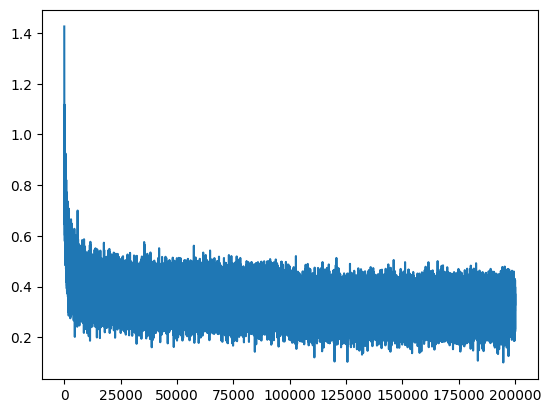

In [463]:
plt.plot(stepi, lossi)

In [464]:
print(loss.item())

2.1341586112976074


In [465]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1154, grad_fn=<NllLossBackward0>)

In [466]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1713, grad_fn=<NllLossBackward0>)

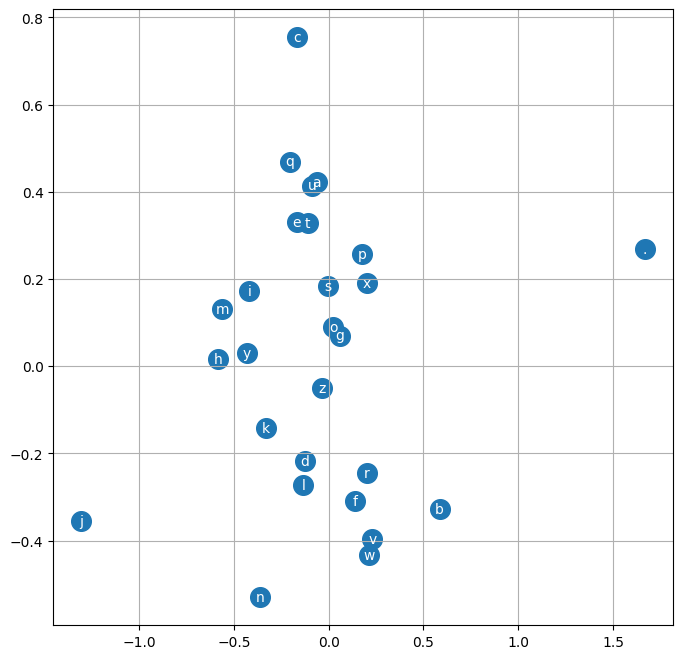

In [467]:
plt.figure(figsize=[8, 8])
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

# spliting data
as parameters grows, this model becomes more capable of overfitting the training set. 
what this means is that the loss on the training set on the data we are training on
will become very low as low a becoming zero but all that the model is doing is
memorizing our training set verbatim. 

training split(80%), dev/validation split(10%), test split(10%)
training split is used for training parameters, dev/validation split for training 
hyper parameters and test split is used for evaluate the performance of the model.

# Analogy:
Imagine you're a student preparing for a history exam. To study, you memorize every single detail of the textbook, including dates, names, footnotes, and even typos. On the exam, instead of general questions about historical events, the teacher gives you slightly different questions about the same topics.

If you've only memorized the textbook word-for-word (overfitting), you might struggle to answer the new questions because you didn’t focus on understanding the broader concepts or themes.
On the other hand, if you'd studied the general ideas, themes, and patterns in history (generalizing), you'd perform well on the exam because you can apply your knowledge flexibly, even if the questions are a bit different.
In this analogy:

Memorizing the textbook = Overfitting (the model learns the "training data" too specifically).
Understanding history broadly = Generalizing (the model captures the underlying patterns).
The slightly different exam = Test data (new, unseen data).

In [468]:
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch .tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

mora.
kayah.
seel.
niha.
ala.
emmaniendraige.
zeredieliia.
miloen.
edelson.
anar.
katelos.
kalin.
shabergias.
jest.
jair.
jelipanthona.
ube.
ged.
rhylene.
ehs.
